# Predicting Used Car Depreciation Using BARTs

*Unit 8 Project*

In this project, I'm going to use a car's year, kilometers drive, latest new price, and number of previous owners to predict how much it's value will depreciate using BARTs.

In [15]:
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb

Let's start by importing our data from GitHub.

I'm also going to create a new column, Percent_Decrease, which will track what percent of the car's value was lost when it was sold. This gives us a standard value to work with, so we can account for cars of a wide variety of prices.

In [16]:
url = "https://raw.githubusercontent.com/blortle-dev/data-science-lasa/refs/heads/main/resources/cars.csv"

data = pd.read_csv(url)

data['Percent_Decrease'] = (data['Present_Price'] - data['Selling_Price']) / data['Present_Price'] * 100

In [17]:
# Print out the data to make sure everything looks right.

data

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Percent_Decrease
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,40.071556
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,50.209644
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,26.395939
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,31.325301
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,33.042213
...,...,...,...,...,...,...,...,...,...,...
296,city,2016,9.50,11.60,33988,Diesel,Dealer,Manual,0,18.103448
297,brio,2015,4.00,5.90,60000,Petrol,Dealer,Manual,0,32.203390
298,city,2009,3.35,11.00,87934,Petrol,Dealer,Manual,0,69.545455
299,city,2017,11.50,12.50,9000,Diesel,Dealer,Manual,0,8.000000


Looks good! Now, we can start to make our BART model. I'm using four features:
- Year
- Kilometers Driven
- Number of Previous Owners
- Latest New Price

to predict how much the car's value will depreciate.

In [18]:
features = ["Year", "Kms_Driven", "Owner", "Present_Price"]

X = data[features]
Y = data["Percent_Decrease"]

Now that our BART's features are ready, we can make the model. I used the code from the Unit 8 Notes AK to make this. I'm also going to run eight chains since I don't have that much data and want more precision.

In [19]:
with pm.Model() as model_cars:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y)
    idata_cars = pm.sample(compute_convergence_checks=False, chains=8, cores=4)

Multiprocess sampling (8 chains in 4 jobs)
CompoundStep
>NUTS: [s]
>PGBART: [μ_]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 79 seconds.


Model's ready! Now, I'll plot the posterior predictive check to see how well it fits our data.

Sampling: [y]


Output()

<Axes: xlabel='y'>

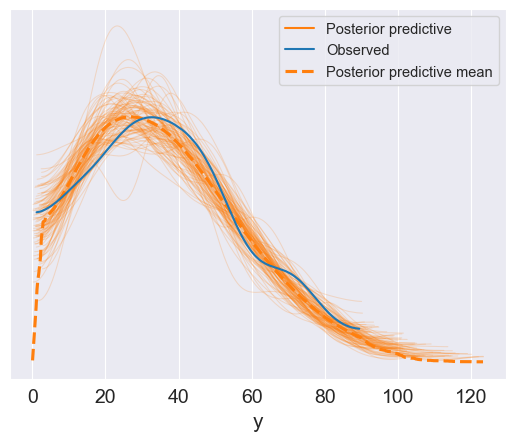

In [20]:
pm.sample_posterior_predictive(idata_cars,model_cars, extend_inferencedata=True)
az.plot_ppc(idata_cars, num_pp_samples=100, colors=["C1", "C0", "C1"])

This is a good fit! The PPC shows that our model is pretty close to our observed data, and should be decently accurate.

I'm going to make some scatter plots now, to try and get an idea of how my individual features are distributed.

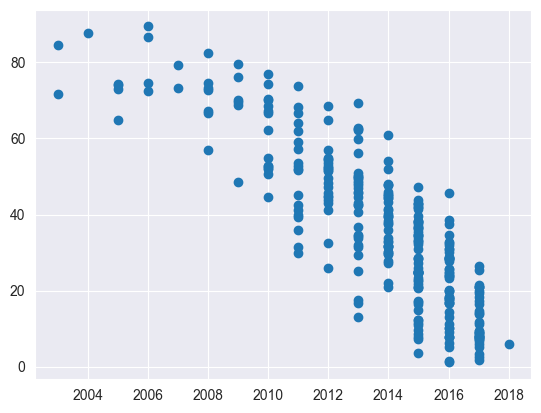

In [21]:
plt.scatter(x=data["Year"], y=data["Percent_Decrease"])

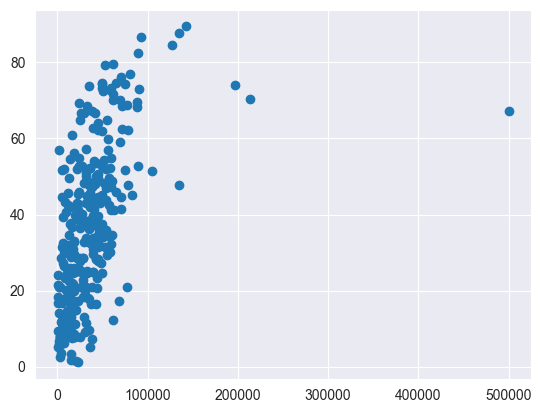

In [22]:
plt.scatter(x=data["Kms_Driven"], y=data["Percent_Decrease"])

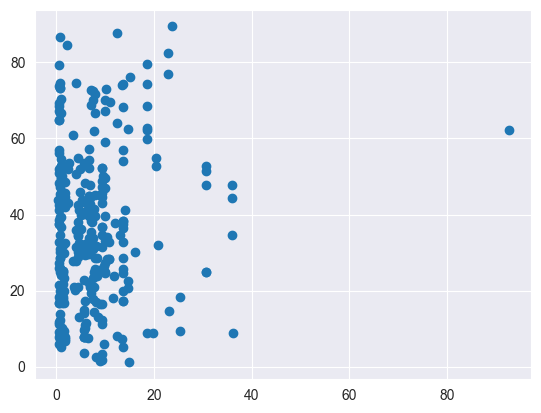

In [23]:
plt.scatter(x=data["Present_Price"], y=data["Percent_Decrease"])

Interesting. Looks like the present price doesn't have too much of an effect on our data output from this scatter plot, but we'll check this later with our VI plot.

After looking over these scatter plots, the Year looks like it has the most consistent relationship with the percent decrease, going down the newer the car is (as expected). Kilometers driven also looks to have a good relationship, but it's a bit less consistent. I didn't look at the number of previous owners, as it's values only range between 0 and 3, so I doubt it has much of an effect on our model.

Okay, let's look at the graphs now.
I'll start with the partial dependence plot:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


array([<Axes: xlabel='Year'>, <Axes: xlabel='Kms_Driven'>,
       <Axes: xlabel='Owner'>, <Axes: xlabel='Present_Price'>],
      dtype=object)

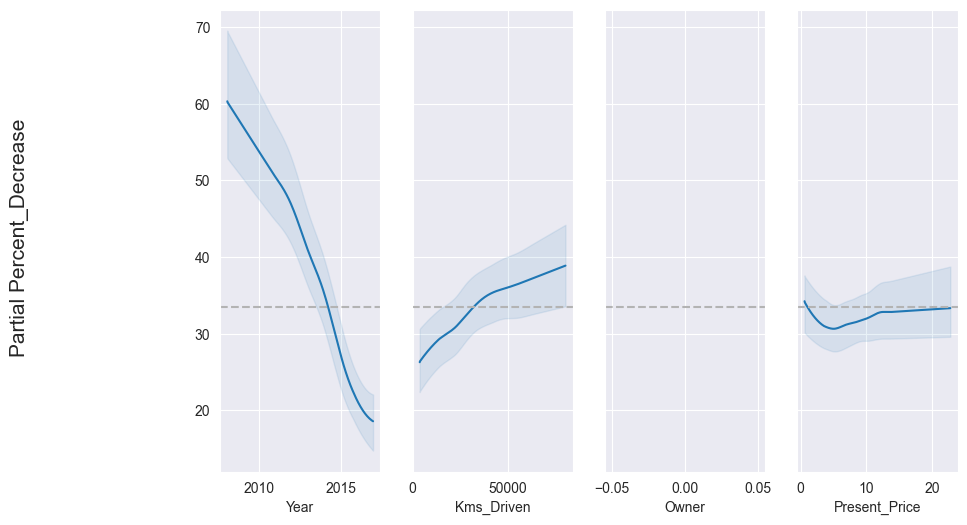

In [24]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

That's interesting, the owner box doesn't contain any lines. We'll come back to that later.

Moving on:

array([<Axes: xlabel='Year'>, <Axes: xlabel='Kms_Driven'>,
       <Axes: xlabel='Owner'>, <Axes: xlabel='Present_Price'>],
      dtype=object)

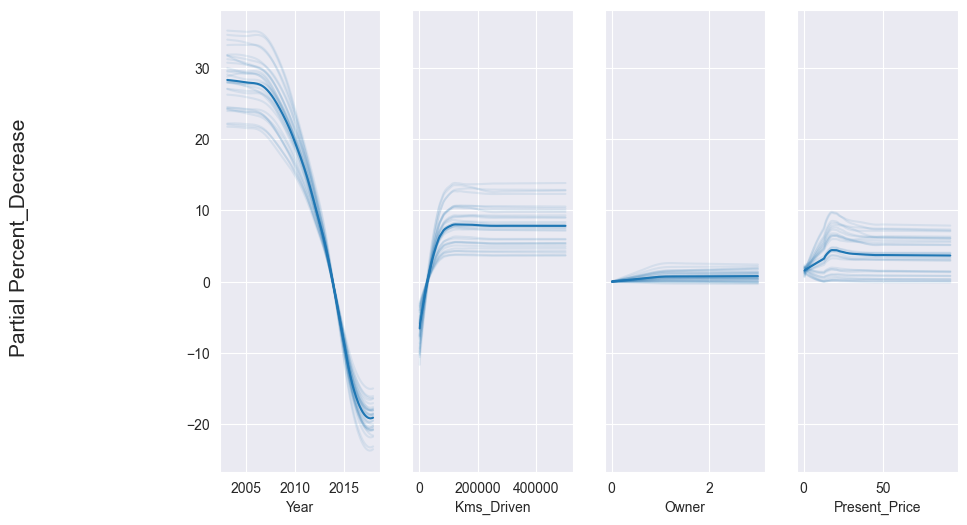

In [25]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

Okay, there. Now we see something in the owner box. Still doesn't look like a very strong trend.

Here's the important part now, the variable importance. We'll use this to check our conclusions from the scatter plots earlier:

<Axes: ylabel='R²'>

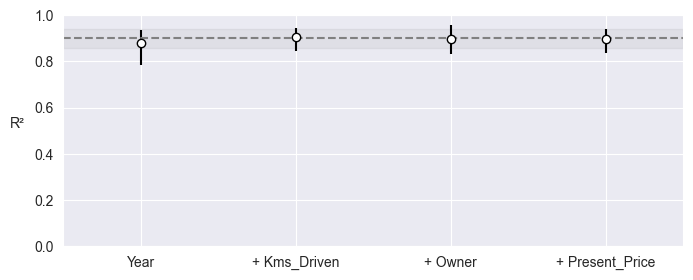

In [26]:
vi = pmb.compute_variable_importance(idata_cars, μ_, X)

pmb.plot_variable_importance(vi)

Let's zoom in closer to get a better idea of the variable importance.

(0.8, 1.0)

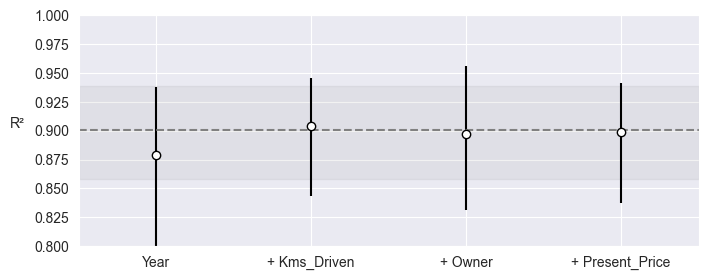

In [27]:
pmb.plot_variable_importance(vi)
plt.ylim(0.8,1)

# Conclusion

Looking over our final model, I think it's pretty good at predicting the value depreciation on used cars, and I think that it shows interesting trends on what factors are most important in determining this.

Looking at the variable importance graph, it looks like kilometers driven has the greatest influence on the percent decrease, which surprised me as I thought Year might have more. Just to test this, I'll make a model with **just** the kilometers driven as the feature, and see how it's accuracy compares to the full model:

In [30]:
features_km = ["Kms_Driven"]

X_km = data[features_km]
Y_km = data["Percent_Decrease"]

In [31]:
with pm.Model() as model_cars_km:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X_km, np.log(Y_km), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y_km)
    idata_cars_km = pm.sample(compute_convergence_checks=False, chains=8, cores=4)

Multiprocess sampling (8 chains in 4 jobs)
CompoundStep
>NUTS: [s]
>PGBART: [μ_]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 66 seconds.


Done! Now, let's look at it's posterior predictive check:

Sampling: [y]


Output()

<Axes: xlabel='y'>

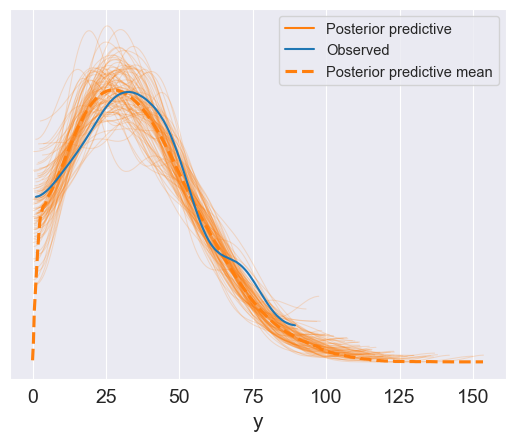

In [32]:
pm.sample_posterior_predictive(idata_cars_km,model_cars_km, extend_inferencedata=True)
az.plot_ppc(idata_cars_km, num_pp_samples=100, colors=["C1", "C0", "C1"])

To make it easier to compare, I've compared the peaks of both models below:

![Model Comparison](https://raw.githubusercontent.com/blortle-dev/data-science-lasa/refs/heads/main/assets/comparison.png)

That's interesting. The kilometers-only model looks to be just as close to the observed data, if not slightly closer. This is an interesting way to see how much the other features are influencing the model. I wonder, what would happen if I made a model with every feature **except** kilometers driven:

In [33]:
features_2 = ["Year", "Owner", "Present_Price"]

X_2 = data[features_km]
Y_2 = data["Percent_Decrease"]

In [34]:
with pm.Model() as model_cars_2:
    s = pm.HalfNormal('s',1000)
    μ_ = pmb.BART("μ_", X_2, np.log(Y_2), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Gamma("y", mu=μ, sigma=s,  observed=Y_2)
    idata_cars_2 = pm.sample(compute_convergence_checks=False, chains=8, cores=4)

Multiprocess sampling (8 chains in 4 jobs)
CompoundStep
>NUTS: [s]
>PGBART: [μ_]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 95 seconds.


Sampling: [y]


Output()

<Axes: xlabel='y'>

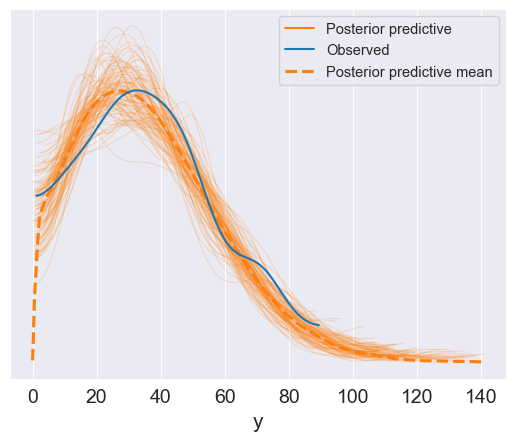

In [35]:
pm.sample_posterior_predictive(idata_cars_2,model_cars_2, extend_inferencedata=True)
az.plot_ppc(idata_cars_2, num_pp_samples=100, colors=["C1", "C0", "C1"])

Interesting. Here's another comparison with all three models:

![Model Comparison](https://raw.githubusercontent.com/blortle-dev/data-science-lasa/refs/heads/main/assets/comparison_2.png)

This doesn't look as accurate, but it still looks close.

I still think that the Kms_Driven only model provided the best results, and is the most accurate model I made for predicting the depreciation of a car's value.